## Analysis of normative curves of morphological hippocampi

This notebook is used to create Supplementary Figure 1B and Figure 2A of the manuscript

- Create normative curves of the features in healthy population

- Analyse where the ipsilateral/contralateral and disease controls hippocampi fell onto the percentiles of the healthy population

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
from aidhs.paths import BASE_PATH 
from aidhs.aidhs_cohort_hip import AidhsCohort, AidhsSubject
from matplotlib.gridspec import GridSpec
from aidhs.data_preprocessing import extract_totalbrainvolume_freesurfer


Setting DATA_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals
Setting BASE_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals
Setting EXPERIMENT_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals
Setting PARAMS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals
Setting FS_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/output/fs_outputs
Setting HIPPUNFOLD_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/output/hippunfold_outputs
Setting BIDS_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/output/bids_outputs


In [2]:
hemis=['lh', 'rh']

#create cohort to smooth
cohort= AidhsCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_avg.hdf5', dataset='dataset_C-P-DC_alltrain.csv')

#get feature list
features = cohort.full_feature_list

#get subjects 
subjects = cohort.get_subject_ids(group='both', lesional_only = False)

len(subjects)

363

In [3]:
features=[
    '.label-{}.curvature.sm1',
    '.label-{}.gauss-curv_filtered_sm1',
    '.label-{}.gyrification.sm1',
    '.label-{}.thickness.sm1',
    '.label-avg.hippunfold_volume',
    '.label-avg.FS_volume',
    #  '.label-avg.hippunfold_volume_icvcorr',
    # '.label-avg.FS_volume_icvcorr',
    ]

features = ['.combat'+feature.format('avg') for feature in features]


features_title = {
                '.curvature' : ' mean curvature',
                '.gauss-curv_filtered': 'intrinsic curvature ',
                '.gyrification' : 'gyrification ',
                '.thickness' : 'thickness (mm) ',
                '.hippunfold_volume' :'volume (mm$^3$)',
    }

In [5]:
# create dataframe with subjects features and demographic information

def is_nan(x):
    return (x != x)

ages = []

df=pd.DataFrame()
for subject in subjects:
    # create subject object
    subj = AidhsSubject(subject, cohort=cohort)
    group=subj.get_demographic_features("group")
    if group=='P':
        lesional_hemi = subj.get_demographic_features("Lesional hemi")
    elif group=='DC':
        lesional_hemi = random.choice(['lh','rh'])   #random choice
    else:
        lesional_hemi = random.choice(['lh','rh'])   #random choice
    #initialise segmentations folders
    id_FS, folder_FS = subj.get_demographic_features(["Freesurfer_ids", "Freesurfer_folder"])
    #get total ICV
    tiv =  extract_totalbrainvolume_freesurfer(os.path.join(folder_FS, id_FS))
    for hemi in hemis:
        values={}
        #get demographic info 
        values['ID']=subj.subject_id
        values['group']=group
        values['hemi'] = hemi
        values['site'], values['age_scan'], values['sex'], values['mri_neg'], values['age_onset'], values['epilepsy_duration']= subj.get_demographic_features(["Site","Age at preoperative", "Sex", "Ever reported MRI negative", "Age of onset of epilepsy","Duration of Epilepsy"])
        if is_nan(lesional_hemi):
            values['lesional'] = np.nan
        elif hemi==lesional_hemi:
            values['lesional'] = 'ipsi'
        else:
            values['lesional'] = 'contra'
        #get structural and intensity features        
        for feature in features:
            vals = subj.load_feature_values(feature, hemi)
            if vals.sum()!=0:
                values[feature]=vals[0]
            else:
                pass
        values['.label-avg.total_volume'] = tiv
        # save values for each subject in panda matrix
        df2 = pd.DataFrame([values])
        df = pd.concat([df,df2],ignore_index=True)


In [4]:
# #load or save dataframe
output_path=os.path.join(BASE_PATH,'data_saved')
file = os.path.join(output_path,'matrix_features_combat_avg_with_tiv_240504.csv')   
# df.to_csv(file)
df=pd.read_csv(file, header=0,encoding='unicode_escape', index_col=0)

In [5]:
df.head()

,ID,group,hemi,site,age_scan,sex,mri_neg,age_onset,epilepsy_duration,lesional,.combat.label-avg.curvature.sm1,.combat.label-avg.gauss-curv_filtered_sm1,.combat.label-avg.gyrification.sm1,.combat.label-avg.thickness.sm1,.combat.label-avg.hippunfold_volume,.combat.label-avg.FS_volume,.label-avg.total_volume
0,MELDH29P0001,P,lh,H29,43.0,0.0,0.0,17.0,26.0,ipsi,0.190748,0.036680,2.176642,1.432983,1751.3384,3106.6167,1312003
1,MELDH29P0001,P,rh,H29,43.0,0.0,0.0,17.0,26.0,contra,0.177748,0.031206,2.544395,1.472283,2179.5810,4121.9653,1312003
2,MELDH29P0002,P,lh,H29,26.0,1.0,0.0,0.8,25.2,ipsi,0.222976,0.034936,2.117792,1.375277,1561.5272,2963.8160,1012007
3,MELDH29P0002,P,rh,H29,26.0,1.0,0.0,0.8,25.2,contra,0.171138,0.028760,2.824229,1.459554,2542.4072,4249.6300,1012007
4,MELDH29P0003,P,lh,H29,20.0,0.0,0.0,13.0,7.0,ipsi,0.203764,0.040068,1.849356,1.435530,1412.2097,3304.8990,1340239


### Plot normative curves of morphological features in healthy population

In [4]:
def return_features_title(feature, features_title):
    for feat in set(features_title):
        if feat in feature:
            return features_title[feat]

def plot_controls_chart(ax, data_c, feature, color = 'green', cmap=False, fill_color=True, label=None):
    if cmap != False:
        cmap = matplotlib.cm.get_cmap(cmap)

    #plot percentiles 
    percentiles = np.sort(list(set(data_c['predict_vals_intervals'])))
    for p, percentile in enumerate(percentiles):
        if cmap != False:
            color = cmap(abs(0.5-percentile))
        if percentile == 0.5:
            ax.plot(data_c['age_range'],data_c['predict_vals_intervals'][percentile], color=color, 
                        ls='-', linewidth= 1, alpha=1, label = label)
        else:
            ax.plot(data_c['age_range'],data_c['predict_vals_intervals'][percentile], color=color, 
                        ls='--',linewidth= 1,  alpha=1)
        # ax.text(data_c['age_range'][-1], data_c['predict_vals_intervals'][percentile][-1], f'{int(percentile*100)}',
        #             fontsize = 10, color=color)   
    
    #fill between line
    if fill_color:
        if len(percentiles)>1:
            bands = np.delete(percentiles, np.where(percentiles == 0.5))
            colors = np.linspace(0,1,len(bands)-1)-0.5
            for b, band in enumerate(bands[0:-1]):
                color = cmap(abs(colors[b]))
                ax.fill_between(data_c['age_range'], data_c['predict_vals_intervals'][band], data_c['predict_vals_intervals'][bands[b+1]], 
                                        facecolor=color, alpha=0.5, interpolate=True)

    #details plot 
    ax.set_xlim([data_c['age_range'][0], data_c['age_range'][-1]])
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=4)
    ax.tick_params(which='minor', length=2)
    ax.set_ylabel(return_features_title(feature, features_title), fontsize=15)
    ax.set_xlabel('age (years)', fontsize=12)


def fit_GAM_age_sex_tiv(vals, age, sex, tiv, fit_log=False, percents=np.array([0.95]), splines=5, add_mid_curve=True):
    from pygam import ExpectileGAM, LinearGAM, s, f, l
    X = np.zeros((len(vals),3))
    if fit_log:
        X[:,0]=np.log(age)
    else:
        X[:,0]=age
    X[:,1]=sex
    X[:,2]=tiv
    y=vals

    # lets fit the mean model first by CV
    # fit spline on age, fraction on sex and linear on TIV
    gam50 = ExpectileGAM(s(0) + f(1) + l(2), expectile=0.5).gridsearch(X, y)
    # and copy the smoothing to the other models
    lam = gam50.lam

    #create grid age
    if fit_log:
        age_range_log=np.linspace(1.3,4.2,100)
        age_range = np.exp(age_range_log)
        XX = np.zeros((len(age_range),3))
        XX[:,0]=age_range_log
    else:
        age_range = np.linspace(3,65,100)
        XX = np.zeros((len(age_range),3))
        XX[:,0]=age_range

    #create grid tiv
    tiv_range= np.linspace(800000,1800000,100)
    
    data_dict = {}
    for sex_ind in [0,1]:
        data_dict[sex_ind]={}
        XX[:,1] = np.ones(len(XX))*sex_ind

        for tiv_ind in tiv_range:
            data_dict[sex_ind][tiv_ind]={}
        
            tiv_array = np.ones(len(XX))*tiv_ind
            XX[:,2] = np.ones(len(XX))*tiv_ind

            data_dict[sex_ind][tiv_ind]['age_range'] = age_range
            data_dict[sex_ind][tiv_ind]['tiv_range'] = tiv_range
            
            predict_vals_intervals=[]
            data_dict[sex_ind][tiv_ind]['predict_vals_intervals']={}
            for percent in percents:
                gam = ExpectileGAM(expectile=percent, lam=lam, n_splines=splines).fit(X, y)
                predict_vals_intervals = gam.predict(XX)
                data_dict[sex_ind][tiv_ind]['predict_vals_intervals'][percent] = predict_vals_intervals
    
            if add_mid_curve == True:   
                data_dict[sex_ind][tiv_ind]['predict_vals_intervals'][0.5] = gam50.predict(XX)

    return data_dict


In [8]:
output_path=os.path.join(BASE_PATH,'images')

#### Plot GAM curves for controls

ModuleNotFoundError: No module named 'pygam'

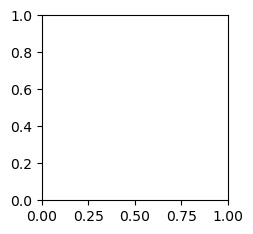

In [ ]:
from matplotlib.gridspec import GridSpec

sub_features=[
# '.combat.label-avg.hippunfold_volume_icvcorr',
'.combat.label-avg.hippunfold_volume',
 '.combat.label-avg.thickness.sm1',
 '.combat.label-avg.gyrification.sm1',
 '.combat.label-avg.curvature.sm1',
 '.combat.label-avg.gauss-curv_filtered_sm1',
 ]

x_variable = 'age_scan' 
sexes=['male','female']
colors_maps = ['Blues_r', 'Red_s']
colors = ['blue', 'red']
fit_GAM=True
fit_log=True
percents = np.array([0.05,0.95])

fig = plt.figure(figsize=(6,18))
gs1 = GridSpec(6, 2, wspace=0.5, hspace=0.3)
axs = []

#plot small TIV 

matrix_coefs= np.zeros((len(sub_features),3))
matrix_pvals= np.zeros((len(sub_features),3))

for i,feature in enumerate(sub_features):
    axs.append(fig.add_subplot(gs1[i]))
    subdf = df.dropna(subset=[feature])


    #plot controls 
    subdf_c = subdf[subdf['group']=='C']
    sex_c = subdf_c['sex'].copy()
    age_c = subdf_c['age_scan'].copy()
    tiv_c = subdf_c['.label-avg.total_volume'].copy()
    vals_c = subdf_c[feature].copy()

    if fit_GAM:
        controls_GAM = fit_GAM_age_sex_tiv(vals_c, age_c, sex_c, tiv_c, fit_log=fit_log, percents=percents, splines=4,  add_mid_curve=True)
    
    # plot max and min TIV curves
    tiv_min = 800000.0
    tiv_max = 1800000.0
    sex_i = 1  # fix sex to female
    mask=(sex_c == sex_i)
    axs[i].scatter(age_c[mask],vals_c[mask],c=colors[sex_i], s=3, alpha=0.5, label=f'healthy female controls')
    im = plot_controls_chart(axs[i], controls_GAM[sex_i][tiv_min], feature, color='blue', fill_color=False, label=f'percentiles GAM curves - min TIV  ')
    im = plot_controls_chart(axs[i], controls_GAM[sex_i][tiv_max], feature, color='red', fill_color=False, label=f'percentiles GAM curves - max TIV  ')
# axs[0].legend()
    
plt.tight_layout()



(-0.05, 1.05, -0.05, 1.05)

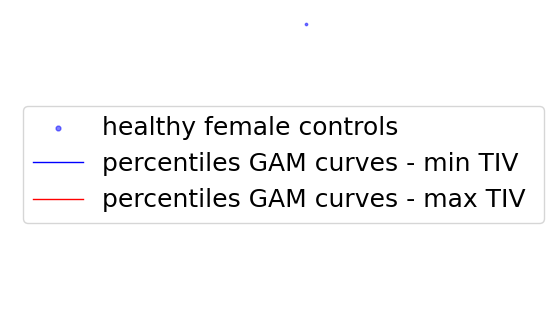

In [40]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(1,1, c='blue', s=3, alpha=0.5, label=f'healthy female controls')
ax.plot([0,0],[0,0], c='blue', ls='-', linewidth= 1, alpha=1,  label=f'percentiles GAM curves - min TIV ')
ax.plot([0,0],[0,0], c='red', ls='-', linewidth= 1, alpha=1,  label=f'percentiles GAM curves - max TIV ')

h, l =  ax.get_legend_handles_labels() # get labels and handles from ax1
ax.legend(h, l, markerscale=2., scatterpoints=1, loc='center left', fontsize=18)
ax.axis('off')

# fig.savefig(os.path.join(output_path, 'legend_charts_combat_features_controls.png'), dpi=96, transparent =True, bbox_inches = 'tight' )

#### Compute percentiles for each subject

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:  00:00:00


 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
/home/mathilde/anaconda3/envs/neohip3.8/lib/python3.8/site-packages/pygam/pygam.py:225: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (self.terms is not 'auto') and not (isinstance(self.terms, (TermList, Term, type(None)))):
/home/mathilde/anaconda3/envs/neohip3.8/lib/python3.8/site-packages/pygam/pygam.py:276: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.terms is 'auto':
/home/mathilde/anaconda3/envs/neohip3.8/lib/python3.8/site-packages/pygam/pygam.py:225: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (self.terms is not 'auto') and not (isinstance(self.terms, (TermList, Term, type(None)))):
/home/mathilde/anaconda3/envs/neohip3.8/lib/python3.8/site-packages/pygam/pygam.py:276: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.terms is 'auto':
/home/mathilde

KeyboardInterrupt: 

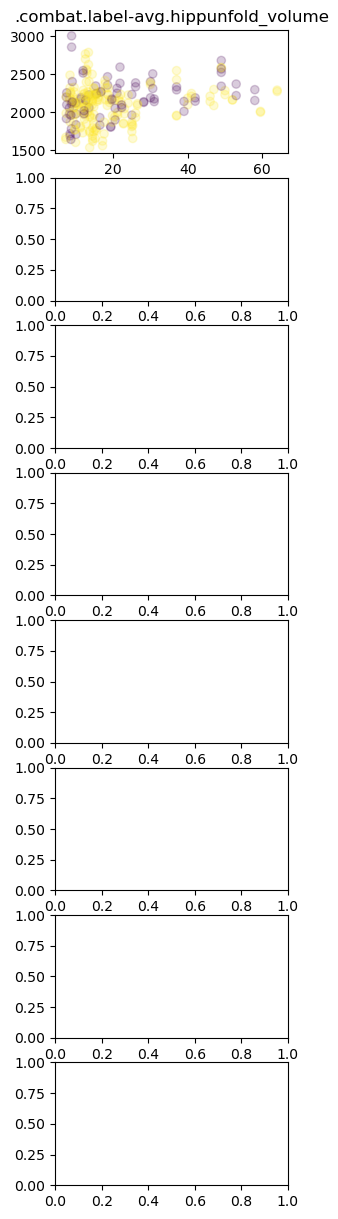

In [10]:
import numpy as np

sub_features=[
# '.combat.label-avg.hippunfold_volume_icvcorr',
'.combat.label-avg.hippunfold_volume',
 '.combat.label-avg.thickness.sm1',
 '.combat.label-avg.gyrification.sm1',
 '.combat.label-avg.curvature.sm1',
 '.combat.label-avg.gauss-curv_filtered_sm1',
 ]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

tiv_range= np.linspace(800000,1800000,100)

fig, axs = plt.subplots(len(features),1, figsize=(3,15))
fit_log=True

for ii,feature in enumerate(sub_features):
    subdf = df.dropna(subset=[feature])
    subdf_c = subdf[subdf['group']=='C']

    val = np.array(subdf_c[feature].copy())
    age = np.array(subdf_c['age_scan'].copy())
    sex = np.array(subdf_c['sex'].copy())
    tiv = np.array(subdf_c['.label-avg.total_volume'].copy())
    
    #plot scatter point
    axs[ii].scatter(age, val, c=sex, alpha=0.2)
    axs[ii].set_title(feature)
    #create 100 curves from 0 to 100 centiles for male and female
    centiles = np.linspace(0.01,0.99, 99)
    data_dict = fit_GAM_age_sex_tiv(val, age, sex, tiv, fit_log=fit_log, percents=centiles, splines=4)
    #organise in matrix for each sex
    gams_predict_dict={}
    for sex_ind in [0,1]:
        gams_predict_dict[sex_ind]={}
        for tiv_ind in tiv_range:
            age_range = data_dict[sex_ind][tiv_ind]['age_range']
            gams_predict = []
            for c, centile in enumerate(centiles):
                gams_predict.append(data_dict[sex_ind][tiv_ind]['predict_vals_intervals'][centile])
            gams_predict_dict[sex_ind][tiv_ind] = np.array(gams_predict)
    
    centiles = centiles*100
    #For the subject age and sex, find how many rows are below the feature values of the subject (this will be the percentile)
    val_centiles_norm = []
    for i, row in df.iterrows():
        subject_age = row['age_scan']
        subject_sex = row['sex']
        subject_tiv = row['.label-avg.total_volume']
        subject_val = row[feature]
        #find the nearest age
        idx_age, age_XX = find_nearest(age_range, subject_age)
        #find nearest TIV
        idx_tiv, tiv_XX = find_nearest(tiv_range, subject_tiv)
        if subject_val > gams_predict_dict[subject_sex][tiv_XX][:, idx_age].max():
            pred_centile = 100
        elif subject_val < gams_predict_dict[subject_sex][tiv_XX][:, idx_age].min():
            pred_centile = 0
        else:
            pred_centile = centiles[np.where(gams_predict_dict[subject_sex][tiv_XX][:, idx_age] > subject_val)[0][0]]
        val_centiles_norm.append(pred_centile)

    #save the percentile values for each hippocampi feature
    df[f'.normCent{feature}'] = val_centiles_norm


In [51]:
# #load or save dataframe
output_path=os.path.join(BASE_PATH,'data_saved')
file = os.path.join(output_path,'percentiles_tiv_corr_240505.csv')   
df.to_csv(file)
# df=pd.read_csv(file, header=0,encoding='unicode_escape', index_col=0)

#### Compare distribution of percentiles in patients 

In [5]:
# #load or save dataframe
output_path=os.path.join(BASE_PATH,'data_saved')

file = os.path.join(output_path,'percentiles_tiv_corr_240506.csv')   
df_tiv=pd.read_csv(file, header=0,encoding='unicode_escape', index_col=0)

file = os.path.join(output_path,'percentiles_240505.csv')   
df_nontiv=pd.read_csv(file, header=0,encoding='unicode_escape', index_col=0)


df_merge = df_tiv.merge(df_nontiv, how='inner', on=['ID', 'group', 'hemi', 'site', 'age_scan', 'sex', 'lesional'], suffixes=('_tiv', '_nontiv'))


In [6]:
df_merge.head()

,ID,group,hemi,site,age_scan,sex,mri_neg_tiv,age_onset_tiv,epilepsy_duration_tiv,lesional,...,.combat.label-avg.hippunfold_volume_icvcorr,.combat.label-avg.FS_volume_icvcorr,.normCent.combat.label-avg.curvature.sm1_nontiv,.normCent.combat.label-avg.gauss-curv_filtered_sm1_nontiv,.normCent.combat.label-avg.gyrification.sm1_nontiv,.normCent.combat.label-avg.thickness.sm1_nontiv,.normCent.combat.label-avg.hippunfold_volume_nontiv,.normCent.combat.label-avg.FS_volume,.normCent.combat.label-avg.hippunfold_volume_icvcorr,.normCent.combat.label-avg.FS_volume_icvcorr
0,MELDH29P0001,P,lh,H29,43.0,0.0,0.0,17.0,26.0,ipsi,...,1733.2833,3062.3877,97.0,100.0,0.0,14.0,0.0,0.0,0.0,0.0
1,MELDH29P0001,P,rh,H29,43.0,0.0,0.0,17.0,26.0,contra,...,2153.0337,4091.5474,65.0,89.0,20.0,61.0,23.0,30.0,17.0,26.0
2,MELDH29P0002,P,lh,H29,26.0,1.0,0.0,0.8,25.2,ipsi,...,1580.4385,3016.2446,100.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MELDH29P0002,P,rh,H29,26.0,1.0,0.0,0.8,25.2,contra,...,2567.2920,4291.9062,14.0,23.0,100.0,77.0,100.0,76.0,100.0,80.0
4,MELDH29P0003,P,lh,H29,20.0,0.0,0.0,13.0,7.0,ipsi,...,1390.6628,3252.7850,100.0,100.0,0.0,27.0,0.0,0.0,0.0,0.0


In [7]:
def bland_altman(data1, data2, ax):
    mean_diff = (data1-data2).mean()
    diff_range = (data1-data2).std()*1.96

    ax.scatter(data1, data1-data2, alpha=.5, s=10)

    ax.hlines(mean_diff, data1.min()-2, data1.max()+2, color="k", linewidth=1)
    ax.text(
        data1.min()-1, mean_diff+.05*diff_range, "mean diff: %.2f"%mean_diff,
        fontsize=10, 
    )

    ax.hlines(
        [mean_diff+diff_range, mean_diff-diff_range],
        data1.min()-2, data1.max()+2, color="k", linewidth=1,
        linestyle="--"
    )
    ax.text(
        data1.min()-1, mean_diff+diff_range+.05*diff_range, 
        "+SD1.96: %.2f"%(mean_diff+diff_range),
        fontsize=8, 
    )
    ax.text(
        data1.min()-1, mean_diff-diff_range+.05*diff_range, 
        "-SD1.96: %.2f"%(mean_diff-diff_range),
        fontsize=8, 
    )

    ax.set_xlim(data1.min()-2, data1.max()+2)
    ax.set_ylim(mean_diff-diff_range*1.5, mean_diff+diff_range*1.5)
    ax.set_xlabel("Means", fontsize=12)
    ax.set_ylabel("Difference", fontsize=12)

    return ax




.combat.label-avg.hippunfold_volume
.combat.label-avg.thickness.sm1
.combat.label-avg.gyrification.sm1
.combat.label-avg.curvature.sm1
.combat.label-avg.gauss-curv_filtered_sm1


/tmp/ipykernel_4077/2981676747.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


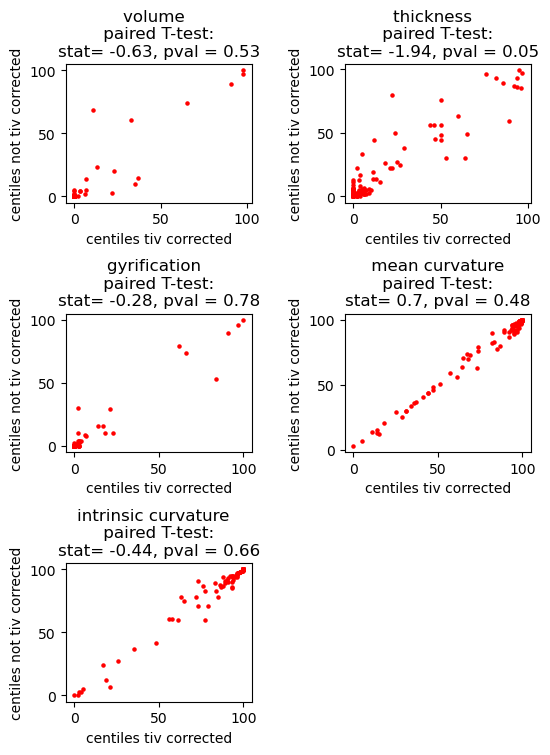

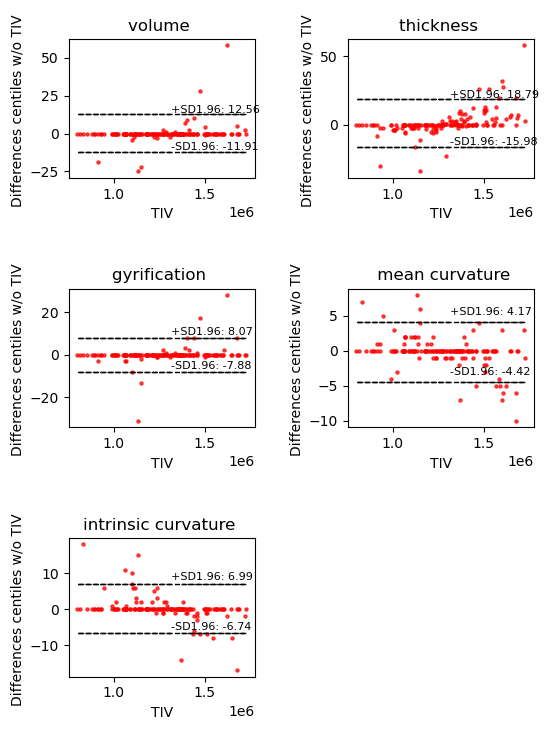

In [20]:
import seaborn as sns
from scipy.stats import ttest_rel
import statsmodels.api as sm

sub_features=[
# '.combat.label-avg.hippunfold_volume_icvcorr',
'.combat.label-avg.hippunfold_volume',
 '.combat.label-avg.thickness.sm1',
 '.combat.label-avg.gyrification.sm1',
 '.combat.label-avg.curvature.sm1',
 '.combat.label-avg.gauss-curv_filtered_sm1',
 ]
features_title = {
                '.curvature' : ' mean curvature',
                '.gauss-curv_filtered': 'intrinsic curvature ',
                '.gyrification' : 'gyrification ',
                '.thickness' : 'thickness ',
                '.hippunfold_volume' :'volume ',
    }

# prepare group
df_merge['class']= df_merge['group']
df_merge.loc[(df_merge.lesional=='ipsi')&(df_merge.group=='P'), 'class'] = 'ipsi'
df_merge.loc[(df_merge.lesional=='contra')&(df_merge.group=='P'), 'class'] = 'contra'
df_merge.loc[df_merge.group=='DC', 'class'] = 'DC'  # take both hippocampi DC
subdf=df_merge.dropna(subset=['class'])


fig = plt.figure(figsize=(6,18))
fig2 = plt.figure(figsize=(6,18))
gs1 = GridSpec(6, 2, wspace=0.5, hspace=0.8)
axs = []
axs2 = []

for i,feature in enumerate(sub_features):
    axs.append(fig.add_subplot(gs1[i]))
    axs2.append(fig2.add_subplot(gs1[i]))

    print(feature)
    feature = f'.normCent{feature}'

    subdf_class = subdf[subdf['class']=='ipsi'].copy()

    tiv_vals = subdf_class[f'{feature}_tiv'].values
    nontiv_vals = subdf_class[f'{feature}_nontiv'].values
    axs[i].scatter(tiv_vals, nontiv_vals, s=5, color='red')
    axs[i].set_xlabel('centiles tiv corrected')
    axs[i].set_ylabel('centiles not tiv corrected')
    
    stat , pval = ttest_rel(tiv_vals, nontiv_vals)
    if pval < 0.01:
        axs[i].set_title(f'{return_features_title(feature, features_title)} \n paired T-test: \nstat= {round(stat,2)}, pval<0.01{"{:.2e}".format(pval)}')
    else: 
        axs[i].set_title(f'{return_features_title(feature, features_title)} \n paired T-test: \nstat= {round(stat,2)}, pval = {round(pval,2)}')

    tiv = subdf_class['.label-avg.total_volume'].values
    diff = nontiv_vals - tiv_vals
    # plt.rcParams['font.size'] = 10
    # # g = sm.graphics.mean_diff_plot(nontiv_vals, tiv_vals, scatter_kwds={'s':1, 'color':'darkblue'}, ax=axs2[i])
    # bland_altman(nontiv_vals, tiv_vals, axs2[i])
    # axs2[i].set_title(return_features_title(feature, features_title))


    axs2[i].scatter(tiv, diff, s=5, color='red', alpha=0.7)
    axs2[i].set_xlabel('TIV')
    axs2[i].set_ylabel('Differences centiles w/o TIV ')
    axs2[i].set_title(f'{return_features_title(feature, features_title)}')
    
    std = diff.std()*1.96
    mean = diff.mean()
    axs2[i].plot(tiv, np.ones(len(tiv))*(mean+std), color="k", linewidth=1, linestyle="--")
    axs2[i].plot(tiv, np.ones(len(tiv))*(mean-std), color="k", linewidth=1, linestyle="--")
    axs2[i].text(tiv[0], mean+std+1,"+SD1.96: %.2f"%(mean+std),fontsize=8,)
    axs2[i].text(tiv[0], mean-std+1,"-SD1.96: %.2f"%(mean-std),fontsize=8,)
plt.tight_layout()

In [21]:
tiv_ipsi = df_tiv[(df_tiv['group']=='P') & (df_tiv['lesional']=='ipsi')]['.label-avg.total_volume'].values
tiv_ipsi.max()

1725648

In [17]:
df_tiv.head()

,ID,group,hemi,site,age_scan,sex,mri_neg,age_onset,epilepsy_duration,lesional,...,.combat.label-avg.hippunfold_volume,.combat.label-avg.FS_volume,.label-avg.total_volume,.normCent.combat.label-avg.curvature.sm1,.normCent.combat.label-avg.gauss-curv_filtered_sm1,.normCent.combat.label-avg.gyrification.sm1,.normCent.combat.label-avg.thickness.sm1,.normCent.combat.label-avg.hippunfold_volume,.normCent.combat.label-avg.FS_volume,class
0,MELDH29P0001,P,lh,H29,43.0,0.0,0.0,17.0,26.0,ipsi,...,1751.3384,3106.6167,1312003,98.0,100.0,0.0,10.0,0.0,0.0,ipsi
1,MELDH29P0001,P,rh,H29,43.0,0.0,0.0,17.0,26.0,contra,...,2179.5810,4121.9653,1312003,66.0,90.0,11.0,54.0,16.0,21.0,contra
2,MELDH29P0002,P,lh,H29,26.0,1.0,0.0,0.8,25.2,ipsi,...,1561.5272,2963.8160,1012007,100.0,93.0,0.0,5.0,0.0,0.0,ipsi
3,MELDH29P0002,P,rh,H29,26.0,1.0,0.0,0.8,25.2,contra,...,2542.4072,4249.6300,1012007,18.0,14.0,100.0,91.0,100.0,95.0,contra
4,MELDH29P0003,P,lh,H29,20.0,0.0,0.0,13.0,7.0,ipsi,...,1412.2097,3304.8990,1340239,100.0,100.0,0.0,27.0,0.0,0.0,ipsi


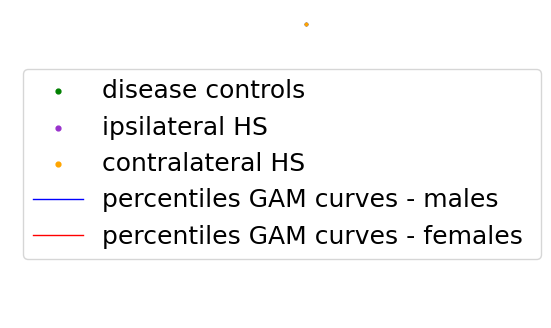

In [14]:
fig, ax = plt.subplots(1,1, figsize=(4,4))


ax.scatter(1,1, c='green',s=3, alpha=1, label='disease controls')
ax.scatter(1,1, c='darkorchid',s=3, alpha=1, label='ipsilateral HS')
ax.scatter(1,1, c='orange',s=3, alpha=1, label='contralateral HS')
for sex_i, sex in enumerate(sexes):
    ax.plot([0,0],[0,0], c=colors[sex_i], ls='-', linewidth= 1, alpha=1,  label=f'percentiles GAM curves - {sex}s ')

h, l =  ax.get_legend_handles_labels() # get labels and handles from ax1
ax.legend(h, l, markerscale=2., scatterpoints=1, loc='center left', fontsize=18)
ax.axis('off')

fig.savefig(os.path.join(output_path, 'legend_charts_combat_features_withpatients.png'), dpi=96, transparent =True, bbox_inches = 'tight' )

In [83]:
# display the number of patients ipsilateral hippocampi outside the 5th and 95th percentiles per feature

subdf_ipsi = df[(df['group']=='P')&(df['lesional']=='ipsi')]
ntot=len(subdf_ipsi)
print(ntot)

percmin = 5
percmax = 95

for feature in sub_features:
    
    npercmin = (subdf_ipsi[f'.normCent{feature}']<=percmin).sum()
    npercmax = (subdf_ipsi[f'.normCent{feature}']>=percmax).sum()
    print(feature)
    print(f'percentage of ipsi HS outside {percmin} population: {round(npercmin/ntot*100,1)}')
    print(f'percentage of ipsi HS outside {percmax} population: {round(npercmax/ntot*100,1)}')

152
.combat.label-avg.hippunfold_volume
percentage of ipsi HS outside 5 population: 90.8
percentage of ipsi HS outside 95 population: 1.3
.combat.label-avg.thickness.sm1
percentage of ipsi HS outside 5 population: 71.1
percentage of ipsi HS outside 95 population: 2.6
.combat.label-avg.gyrification.sm1
percentage of ipsi HS outside 5 population: 91.4
percentage of ipsi HS outside 95 population: 1.3
.combat.label-avg.curvature.sm1
percentage of ipsi HS outside 5 population: 1.3
percentage of ipsi HS outside 95 population: 71.1
.combat.label-avg.gauss-curv_filtered_sm1
percentage of ipsi HS outside 5 population: 3.3
percentage of ipsi HS outside 95 population: 70.4
